In [1]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from pyHalo.preset_models import CDM
from pyHalo import plotting_routines
from pyHalo.utilities import multiplane_convergence
from lenstronomy.LensModel.lens_model import LensModel

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):  # ../../
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs

In [2]:
sample_lens = SampleStrongLens()

m_host = sample_lens.get_main_halo_mass()
log_m_host = np.log10(m_host)
r_tidal = 0.25
sigma_sub = 0.055
subhalo_cone = 6
los_normalization = 0

lens_model_list_macro = sample_lens.lens_model_list[:2]
kwargs_lens_macro = sample_lens.kwargs_lens[:2] 
redshift_list_macro = sample_lens.lens_redshift_list[:2]

sample_realization = CDM(round(sample_lens.z_lens, 2),
            round(sample_lens.z_source, 2),
            sigma_sub=sigma_sub,
            log_mlow=6.,
            log_mhigh=10.,
            log_m_host=log_m_host, 
            r_tidal=r_tidal,
            cone_opening_angle_arcsec=subhalo_cone,
            LOS_normalization=los_normalization)

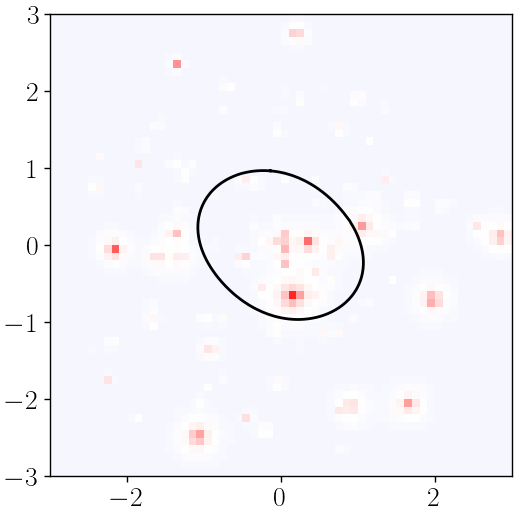

In [3]:
out = plotting_routines.plot_multiplane_convergence(sample_realization, 
                                  npix=60,
                             cone_opening_angle_arcsec=subhalo_cone, 
                             lens_model_list_macro=None, 
                             kwargs_lens_macro=None, 
                             redshift_list_macro=None,
                                 show_critical_curve=True, vmin_max=0.01)

In [4]:
pprint(f'{len(sample_realization.halos)} subhalos in the realization')

'121 subhalos in the realization'


In [5]:
pprint(kwargs_lens_macro)

[{'center_x': 0.04201,
  'center_y': 0.038204,
  'e1': 0.1,
  'e2': 0,
  'theta_E': 0.975908},
 {'gamma1': 0.1, 'gamma2': -0.05}]


In [6]:
npix = 60

delta_kappa, lens_model, kwargs_lens, _, _ = multiplane_convergence(sample_realization, subhalo_cone, npix, lens_model_list_macro, kwargs_lens_macro, redshift_list_macro)

lens_model_list_halos, redshfit_array_halos, kwargs_lens_halos, _ = sample_realization.lensing_quantities()

lens_model_macro = LensModel(lens_model_list_macro)
lens_model = LensModel(lens_model_list_macro + lens_model_list_halos,
                           z_source=sample_realization.lens_cosmo.z_source, multi_plane=True,
                           lens_redshift_list=redshift_list_macro + list(redshfit_array_halos),
                           cosmo=sample_lens.cosmo)

_r = np.linspace(-subhalo_cone/2, subhalo_cone/2, npix)
xx, yy = np.meshgrid(_r, _r)
kappa_macro = lens_model_macro.kappa(xx.ravel(), yy.ravel(), kwargs_lens_macro)
kappa = lens_model.kappa(xx.ravel(), yy.ravel(), kwargs_lens_macro + kwargs_lens_halos)
delta_kappa = (kappa - kappa_macro).reshape(npix, npix)

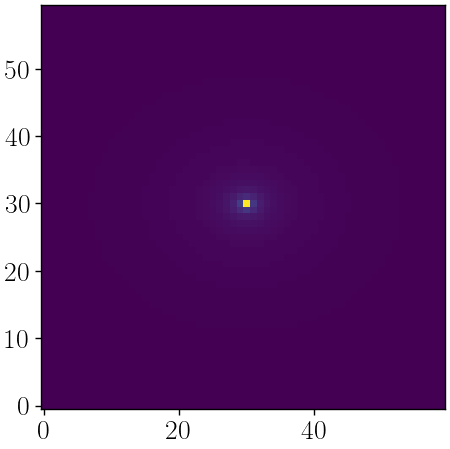

In [7]:
plt.imshow(kappa_macro.reshape(npix, npix))
plt.show()

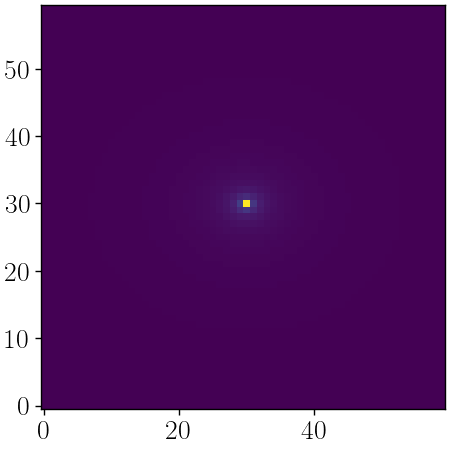

In [8]:
plt.imshow(kappa.reshape(npix, npix))
plt.show()

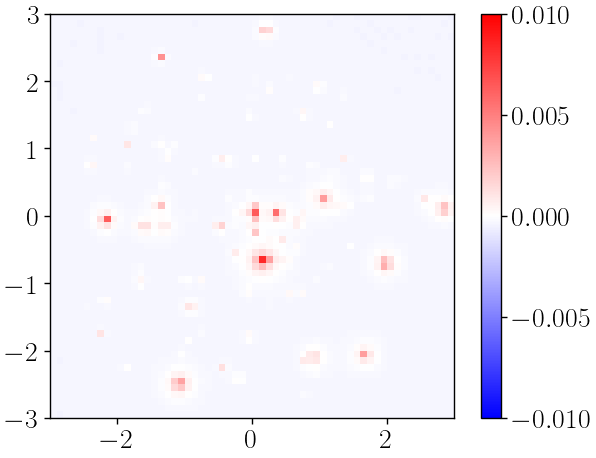

In [9]:
vmin_max = 0.01
plt.imshow(delta_kappa, extent=[-subhalo_cone/2, subhalo_cone/2, -subhalo_cone/2, subhalo_cone/2], vmin=-vmin_max, vmax=vmin_max, cmap='bwr')
plt.colorbar()
plt.show()

# Test methods on StrongLens

In [10]:
sample_lens = SampleStrongLens()

m_host = sample_lens.get_main_halo_mass()
log_m_host = np.log10(m_host)
r_tidal = 0.25
sigma_sub = 0.055
subhalo_cone = 6
los_normalization = 0

# imaging params
band = 'F184'
grid_oversample = 3
num_pix = 45
side = 4.95

sample_realization = CDM(round(sample_lens.z_lens, 2),
            round(sample_lens.z_source, 2),
            sigma_sub=sigma_sub,
            log_mlow=6.,
            log_mhigh=10.,
            log_m_host=log_m_host, 
            r_tidal=r_tidal,
            cone_opening_angle_arcsec=subhalo_cone,
            LOS_normalization=los_normalization)

sample_lens.add_subhalos(sample_realization, suppress_output=False)

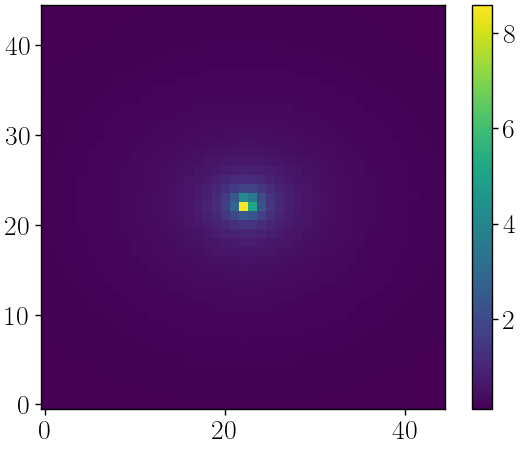

In [11]:
kappa = sample_lens.get_kappa(num_pix, subhalo_cone)

plt.imshow(kappa)
plt.colorbar()
plt.show()

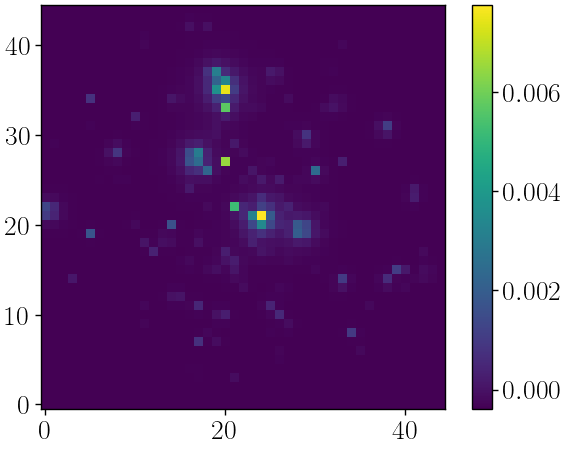

In [12]:
delta_kappa = sample_lens.get_delta_kappa(num_pix, subhalo_cone)

plt.imshow(delta_kappa)
plt.colorbar()
plt.show()

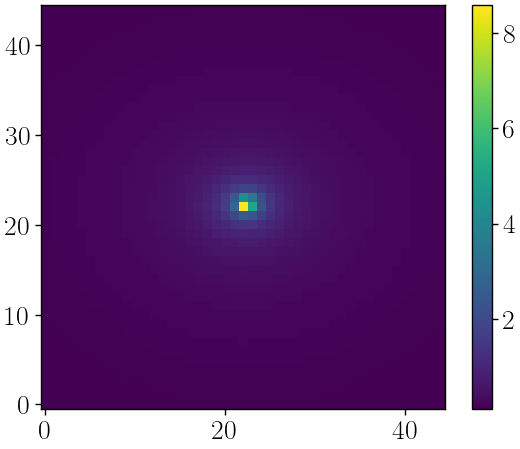

In [13]:
macrolens_kappa = sample_lens.get_macrolens_kappa(num_pix, subhalo_cone)

plt.imshow(macrolens_kappa)
plt.colorbar()
plt.show()

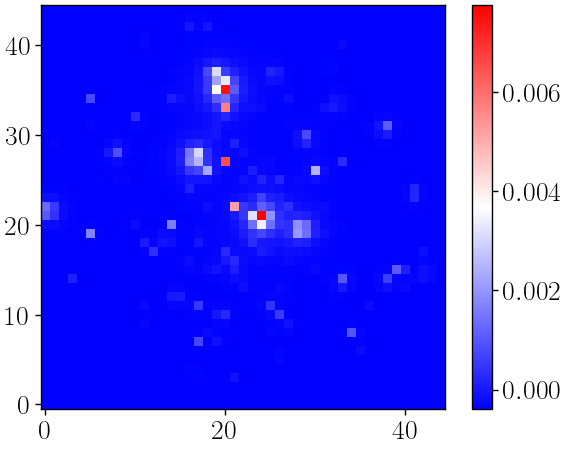

In [14]:
kappa, kappa_macro = sample_lens.get_kappa(num_pix, subhalo_cone, _get_kappa_macro=True)
kappa = kappa.reshape(num_pix, num_pix)
kappa_macro = kappa_macro.reshape(num_pix, num_pix)

plt.imshow(kappa - kappa_macro, cmap='bwr')
plt.colorbar()
plt.show()